## XAIMINIROCKET


### Bloque 1
Carga las librerías usadas en todo el flujo y recarga el módulo minirocket_multivariate_variable por si se lo edita recientemente.

In [1]:
import importlib
import numpy as np
import pandas as pd
from code import minirocket_multivariate_variable as mmv

importlib.reload(mmv)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm import tqdm
import shap


### Bloque 2
Define parámetros globales del experimento.

#### Entradas:

DATA_PATH → aquí se indica la ruta al juego de datos (archivo Parquet).
Ejemplos: "./data/mi_dataset.parquet" o "C:/proyecto/df.parquet".

LABEL_COL → nombre exacto de la columna de etiquetas en el parquet.

TEST_SIZE y RANDOM_STATE se pueden dejar por defecto.

#### Salidas: 
variables de configuración disponibles para los bloques siguientes.

In [2]:
#Cargar el dataset
DATA_PATH = "df_XV.parquet"
LABEL_COL = "RealDifficulty"
TEST_SIZE = 0.20
RANDOM_STATE = 42

# Configuración de canales
C_CHANNELS = 2            # Elección de número de canales
ORDER = "stacked"       

df = pd.read_parquet(DATA_PATH)
print("Shape DF:", df.shape)

# Etiquetas
label_raw = (
    df[LABEL_COL].astype(str).str.strip().str.lower()
      .str.replace("í","i", regex=False)
      .str.replace("á","a", regex=False)
)
mapping_text2id = {"facil":0, "dificil":1}
unknown = sorted(set(label_raw.unique()) - set(mapping_text2id.keys()))
if unknown:
    raise ValueError(f"Valores inesperados en {LABEL_COL}: {unknown}")
y = label_raw.map(mapping_text2id).to_numpy(dtype=int)
print("Mapa etiqueta:", {"FACIL":0, "DIFICIL":1})

# Features -> (n, C, L)
X_feats = df.drop(columns=[LABEL_COL]).to_numpy(dtype=np.float32)

# NaN/Inf guard
if not np.isfinite(X_feats).all():
    print("Aviso: NaN/Inf en X → se reemplazan por 0.")
    X_feats = np.nan_to_num(X_feats, nan=0.0, posinf=0.0, neginf=0.0)

n, F = X_feats.shape
if F % C_CHANNELS != 0:
    raise ValueError(f"Con C={C_CHANNELS}, F={F} no es divisible. Revisa C_CHANNELS/ORDER.")
L = F // C_CHANNELS
print(f"C={C_CHANNELS}  L={L}")

if ORDER == "stacked":
    X = X_feats.reshape(n, C_CHANNELS, L)
elif ORDER == "interleaved":
    X = X_feats.reshape(n, L, C_CHANNELS).transpose(0, 2, 1)
else:
    raise ValueError("ORDER debe ser 'stacked' o 'interleaved'.")

print("X:", X.shape, " | y:", y.shape)

cnt = Counter(y)
strat = y if min(cnt.values()) >= 2 else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=strat
)
print("X_train:", X_train.shape, " | X_test:", X_test.shape, " | clases:", np.unique(y))


Shape DF: (240, 15749)
Mapa etiqueta: {'FACIL': 0, 'DIFICIL': 1}
C=2  L=7874
X: (240, 2, 7874)  | y: (240,)
X_train: (192, 2, 7874)  | X_test: (48, 2, 7874)  | clases: [0 1]



### Bloque 3

Ajusta MiniRocket exclusivamente con X_train, aprendiendo dilataciones, sesgos y selección de canales. Estos parámetros quedan guardados internamente en mmv (estado global).

Transforma X_train a ϕ, devolviendo: Phi_train (n_train × F), la matriz de firmas PPV que se usará para entrenar la LR.

out_train["traces"], metadatos por firma (σ por tiempo, taps κ, dilatación, canales, sesgo), necesarios luego para la atribución temporal β(t).

Finalmente imprime la forma de Phi_train.

#### Entradas requeridas:

X_train con forma (n_train, C, L), preparado en bloques previos.

#### Salidas/efectos:

Estado interno de MiniRocket actualizado.

Phi_train listo para el bloque de LR(ϕ); traces disponibles para explicaciones.

In [3]:

mmv.fit_minirocket_parameters(X_train)

out_train = mmv.transform_prime(X_train)
Phi_train = out_train["phi"]
print("Phi_train:", Phi_train.shape)

clf_phi = make_pipeline(
    StandardScaler(with_mean=False),
    LogisticRegression(max_iter=2000, solver="lbfgs", multi_class="auto", n_jobs=-1)
).fit(Phi_train, y_train)
print("Clasificador LR(ϕ) entrenado.")


mmv.set_phi_classifier_for_logits(clf_phi)
print("model_logit conectado (vía ϕ).")


Phi_test = mmv.transform_prime(X_test)["phi"]
acc = (clf_phi.predict(Phi_test) == y_test).mean()
print("Accuracy test:", acc)

rng = np.random.default_rng(42)
bg_size = min(256, len(X_train))
idx_bg = rng.choice(len(X_train), size=bg_size, replace=False)

phi_bg = np.vstack([mmv.transform_prime(X_train[i:i+1])["phi"] for i in idx_bg])

scaler = clf_phi.named_steps["standardscaler"]
lr     = clf_phi.named_steps["logisticregression"]
phi_bg_scaled = scaler.transform(phi_bg)
mu_bg_scaled  = phi_bg_scaled.mean(axis=0)
print("phi_bg:", phi_bg.shape)


Phi_train: (192, 9996)
Clasificador LR(ϕ) entrenado.
model_logit conectado (vía ϕ).
Accuracy test: 0.625
phi_bg: (192, 9996)


### Bloque 4

##### 1. Construye un background en el espacio ϕ (MiniRocket) a partir de TRAIN

Toma una muestra aleatoria de bg_size = min(128, len(X_train)) instancias de X_train (semilla fija para reproducibilidad).

Aplica mmv.transform_prime a cada instancia y apila sus firmas ϕ en phi_background (B × F).

Este background se usa para:

SHAP LinearExplainer (como referencia de distribución en ϕ).

Obtener la media en ϕ escalado: phi_bg_scaled = scaler.transform(phi_background), y su media mu_bg_scaled.

##### 2. Extrae el scaler y el clasificador lr desde el pipeline

scaler = clf_phi.named_steps["standardscaler"] permite escalar cualquier ϕ.

lr = clf_phi.named_steps["logisticregression"] expone los pesos/coeficientes del modelo en ϕ.

Calcula phi_bg_scaled y su media mu_bg_scaled (vector de tamaño F).

##### 3. Define helpers para baseline por medoide

_ensure_TC y _flatten_tc: aseguran y aplanan la forma temporal–canal para cálculos intermedios.

compute_medoids_by_class: para cada clase, selecciona el medoide (ejemplo más representativo) evaluando distancias en un subconjunto (máx. 300) para eficiencia.

pick_opposite_medoid: dada una instancia x_raw, predice su clase en ϕ y devuelve el medoide de la clase opuesta (baseline de referencia x̄), con fallback si falta.

In [4]:

rng = np.random.default_rng(42)
bg_size = min(128, len(X_train))
idx_bg = rng.choice(len(X_train), size=bg_size, replace=False)

phi_background = np.vstack([ mmv.transform_prime(X_train[k:k+1])["phi"]
                             for k in tqdm(idx_bg, desc="ϕ(background)") ])
print("phi_background:", phi_background.shape)

scaler = clf_phi.named_steps["standardscaler"]
lr     = clf_phi.named_steps["logisticregression"]

phi_bg_scaled = scaler.transform(phi_background)   # (B, F)
mu_bg_scaled  = phi_bg_scaled.mean(axis=0)         # media background en espacio escalado


ϕ(background): 100%|██████████| 128/128 [01:32<00:00,  1.39it/s]

phi_background: (128, 9996)


In [7]:

def compute_channelwise_medoids_by_class(X, y):
    """
    X: (n,C,L), y: (n,)
    Devuelve: {cls: {"x0": (1,C,L) composite, "from_idx": [idx_por_canal]}}
    """
    import numpy as np
    n, C, L = X.shape
    res = {}
    for cls in np.unique(y):
        msk = (y == cls)
        Xc = X[msk]                 # (m,C,L)
        idxs = np.where(msk)[0]
        if len(Xc) == 0: 
            continue
        parts, from_idx = [], []
        for ch in range(C):
            Xi = Xc[:, ch, :]      # (m,L)
            norms = (Xi**2).sum(1, keepdims=True)
            D2 = norms + norms.T - 2.0 * (Xi @ Xi.T)
            D2[D2 < 0] = 0
            j = int(np.argmin(D2.mean(1)))
            parts.append(Xc[j:j+1, ch:ch+1, :])   # (1,1,L)
            from_idx.append(int(idxs[j]))
        x0 = np.concatenate(parts, axis=1)        # (1,C,L)
        res[int(cls)] = {"x0": x0, "from_idx": from_idx}
    return res

def pick_opposite_channelwise_baseline(x_raw, y_true, clf_phi, ch_medoids, fallback_medoids, transform_prime):
    """Intenta baseline canal-wise de la clase opuesta; si no hay, cae al medoide multicanal."""
    opp = 1 - int(y_true)
    if opp in ch_medoids:
        return ch_medoids[opp]["x0"], opp

    phi_x = transform_prime(x_raw)["phi"]
    proba = clf_phi.predict_proba(phi_x)[0]
    classes = clf_phi.classes_
    order = np.argsort(-proba)
    # busca la mejor alternativa distinta a la top predicha
    for j in order[1:]:
        cand = int(classes[j])
        if cand in ch_medoids:
            return ch_medoids[cand]["x0"], cand

    # fallback: medoide multicanal
    if fallback_medoids:
        y_hat = int(classes[order[0]])
        for cand in fallback_medoids:
            if cand != y_hat:
                return fallback_medoids[cand], int(cand)

    raise RuntimeError("No hay baseline canal/medoid opuesta disponible.")


In [9]:

def compute_medoids_by_class(X_src, y_src, max_candidates=300, seed=42):
    """
    X_src: (n, C, L), y_src: (n,)
    Devuelve: {cls: (1, C, L)} con el ejemplo más representativo (medoide) por clase.
    """
    import numpy as np
    rng = np.random.default_rng(seed)
    med = {}
    classes = np.unique(y_src)
    for cls in classes:
        Xc = X_src[y_src == cls]
        m = len(Xc)
        if m == 0:
            continue
        # Submuestrea para acelerar
        idx = np.arange(m)
        if m > max_candidates:
            idx = rng.choice(m, size=max_candidates, replace=False)

        # Aplana (C,L) -> (C*L) para distancias
        flat = np.vstack([Xc[j:j+1][0].reshape(Xc.shape[1]*Xc.shape[2]) for j in idx]).astype(np.float32)  # (m', C*L)
        norms = (flat**2).sum(1, keepdims=True)
        D2 = norms + norms.T - 2.0 * (flat @ flat.T)
        D2[D2 < 0] = 0
        D = np.sqrt(D2, dtype=np.float32)

        j_local = int(np.argmin(D.mean(1)))
        med[int(cls)] = Xc[idx[j_local]:idx[j_local]+1]  # (1, C, L)
    return med


In [10]:

medoids = compute_medoids_by_class(X_train, y_train, max_candidates=300)
ch_medoids = compute_channelwise_medoids_by_class(X_train, y_train)
print("Medoids multicanal:", list(medoids.keys()))
print("Medoids por canal:", list(ch_medoids.keys()))


Medoids multicanal: [0, 1]
Medoids por canal: [0, 1]


In [11]:
# 1) Elegir instancia
i = 0
x_raw  = X_test[i:i+1]       # (1,C,L)
y_true = int(y_test[i])

X0_op, cls_opp = pick_opposite_channelwise_baseline(
    x_raw=x_raw, y_true=y_true, clf_phi=clf_phi,
    ch_medoids=ch_medoids, fallback_medoids=medoids,
    transform_prime=mmv.transform_prime
)
print(f"[inst {i}] y_true={y_true} | baseline(opuesta) -> clase {cls_opp}")


[inst 0] y_true=0 | baseline(opuesta) -> clase 1


In [12]:
# 3) φ y trazas de x y baseline
out_x  = mmv.transform_prime(x_raw)
phi_x, traces = out_x["phi"], out_x["traces"]

out_x0 = mmv.transform_prime(X0_op)
phi_x0, traces0 = out_x0["phi"], out_x0["traces"]

x_tc, x0_tc = x_raw[0].T, X0_op[0].T      # (T,C)
T, C = x_tc.shape

def _ensure_conv_by_channel_series(traces, T, C):
    import numpy as np
    for tr in traces:
        cbc = tr.get("conv_by_channel", None)
        if cbc is None:
            continue
        if isinstance(cbc, dict):
            for ch in list(cbc.keys()):
                v = np.asarray(cbc[ch])
                if v.ndim == 1 and v.shape[0] == T:
                    continue                    # ya es serie (T,)
                if v.ndim == 1 and v.shape[0] == C:
                    cbc[ch] = np.full(T, float(v[int(ch)]), dtype=float)  # expandir
                    continue
                if v.ndim == 0:
                    cbc[ch] = np.full(T, float(v), dtype=float)           # escalar -> serie
                    continue
                raise ValueError(f"conv_by_channel[{ch}] forma inesperada: {v.shape}")
        else:
            arr = np.asarray(cbc)
            if arr.ndim == 1 and arr.shape[0] == C:
                tr["conv_by_channel"] = {i: np.full(T, float(arr[i]), dtype=float) for i in range(C)}
            else:
                raise ValueError(f"conv_by_channel forma inesperada: {arr.shape}")

_ensure_conv_by_channel_series(traces,  T, C)
_ensure_conv_by_channel_series(traces0, T, C)


In [13]:
phi_x_s  = scaler.transform(phi_x)
phi_x0_s = scaler.transform(phi_x0)

def _logit_for_class(model, zz, cls_idx):
    z = model.decision_function(zz)
    z = np.asarray(z)
    return float(z[0] if z.ndim==1 else z[0, cls_idx])

cls_idx = int(np.argmax(clf_phi.predict_proba(phi_x)[0]))
fx  = _logit_for_class(lr, phi_x_s,  cls_idx)
fx0 = _logit_for_class(lr, phi_x0_s, cls_idx)
delta_f = fx - fx0

W = lr.coef_
if W.ndim == 2 and W.shape[0] > 1:
    w_c = W[cls_idx]
else:
    w = W.ravel(); w_c = w if cls_idx == 1 else -w

alphas_raw = (phi_x_s[0] - mu_bg_scaled) * w_c
alphas = mmv.calibrate_alphas_to_delta_f(alphas_raw, delta_f, phi_x_s, phi_x0_s)
print("delta_f:", delta_f, "| sum(alphas):", float(np.sum(alphas)))


delta_f: -9.771738275666308 | sum(alphas): -9.771738275666305


In [14]:

T, C = x_tc.shape

def _coerce_conv_by_channel_series(traces, T, C):
    for tr in traces:
        cbc = tr.get("conv_by_channel", None)
        if cbc is None:
            continue

        # Si viene como dict {canal -> algo}
        if isinstance(cbc, dict):
            for ch in list(cbc.keys()):
                v = np.asarray(cbc[ch])
                # OK: ya es serie temporal por canal
                if v.ndim == 1 and v.shape[0] == T:
                    continue
                # Caso problemático: vector (C,) -> usar su propio elemento y expandir a (T,)
                if v.ndim == 1 and v.shape[0] == C:
                    cbc[ch] = np.full(T, float(v[int(ch)]), dtype=float)
                    continue
                # Escalar -> expandir a (T,)
                if v.ndim == 0:
                    cbc[ch] = np.full(T, float(v), dtype=float)
                    continue
                # Cualquier otra forma: reemplazar por ceros para no romper
                cbc[ch] = np.zeros(T, dtype=float)

        # Si viene como array/lista (C,) -> convertir a dict {canal: serie constante (T,)}
        else:
            arr = np.asarray(cbc)
            if arr.ndim == 1 and arr.shape[0] == C:
                tr["conv_by_channel"] = {i: np.full(T, float(arr[i]), dtype=float) for i in range(C)}
            else:
                # Forma inesperada: mejor limpiarlo
                tr["conv_by_channel"] = {}

def _debug_conv_by_channel(traces, tag):
    bad = []
    for f, tr in enumerate(traces):
        cbc = tr.get("conv_by_channel", None)
        if isinstance(cbc, dict):
            for ch, v in cbc.items():
                v = np.asarray(v)
                if not (v.ndim == 1 and v.shape[0] == T):
                    bad.append((f, ch, np.shape(v)))
        elif cbc is not None:
            bad.append((f, "array", np.shape(cbc)))
    print(f"[{tag}] conv_by_channel problemas:", len(bad))
    if bad[:5]: print("  ejemplos:", bad[:5])

_coerce_conv_by_channel_series(traces,  T, C)
_coerce_conv_by_channel_series(traces0, T, C)

#debug
_debug_conv_by_channel(traces,  "x")
_debug_conv_by_channel(traces0, "x0")


[x] conv_by_channel problemas: 0
[x0] conv_by_channel problemas: 0


In [15]:
sigma_ref = [tr0["sigma"] for tr0 in traces0]

beta_T1 = mmv.back_propagate_attribution(
    alphas, traces, x_tc, x0_tc,
    sigma_ref=sigma_ref, mode="channel_energy"
)

beta_TC = mmv.back_propagate_attribution(
    alphas, traces, x_tc, x0_tc,
    sigma_ref=sigma_ref, mode="channel_energy",
    per_channel=True
)

print(f"Σβ(T,1)={float(beta_T1.sum()):.6f} | Σβ(T,C)={float(beta_TC.sum()):.6f} | Δf={delta_f:.6f}")
print("cierre canales→tiempo:", np.allclose(beta_TC.sum(axis=1, keepdims=True), beta_T1, atol=1e-12))


Σβ(T,1)=-9.771738 | Σβ(T,C)=-9.771738 | Δf=-9.771738
cierre canales→tiempo: True


In [16]:
contrib_c    = beta_TC.sum(axis=0)         # (C,)
importance_c = np.abs(beta_TC).sum(axis=0) # (C,)
print("Contribución por canal:", contrib_c)
print("Importancia |β| por canal:", importance_c)


Contribución por canal: [ 15.59406264 -25.36580092]
Importancia |β| por canal: [78.15781863 82.05320777]


In [17]:
shares = importance_c / importance_c.sum()
print("Share de actividad (|β|) por canal:", shares)  # ~[0.488, 0.512]


Share de actividad (|β|) por canal: [0.48784294 0.51215706]


In [ ]:
# GUARDAR DIRECTO A CSV
import os, time, numpy as np, pandas as pd

RUN_TAG  = "all"   # "test" para X_test; "all" para todo X
STAMP    = time.strftime("%Y%m%d_%H%M%S")
OUT_DIR  = f"channel_attribs/{RUN_TAG}_{STAMP}"
os.makedirs(OUT_DIR, exist_ok=True)
print("OUT_DIR:", OUT_DIR)

X_run, y_run = (X_test, y_test) if RUN_TAG == "test" else (X, y)

if 'CH_NAMES' in globals():
    CH_NAMES = list(CH_NAMES)
else:
    CH_NAMES = [f"canal_{j}" for j in range(X.shape[1])]
assert len(CH_NAMES) == X.shape[1], "CH_NAMES debe tener C nombres."

pd.DataFrame({"channel_index": list(range(len(CH_NAMES))), "channel_name": CH_NAMES}) \
  .to_csv(os.path.join(OUT_DIR, "channels.csv"), index=False)

try:
    ch_medoids 
except NameError:
    ch_medoids = compute_channelwise_medoids_by_class(X_train, y_train)

try:
    expl = shap.LinearExplainer(lr, phi_bg_scaled)
except Exception:
    expl = shap.explainers.Linear(lr, phi_bg_scaled)

rows = []
for i in range(len(X_run)):
    x_raw  = X_run[i:i+1]              
    y_true = int(y_run[i])

    X0_op, cls_opp = pick_opposite_channelwise_baseline(
        x_raw=x_raw, y_true=y_true, clf_phi=clf_phi,
        ch_medoids=ch_medoids, fallback_medoids=None,
        transform_prime=mmv.transform_prime
    )
    med_idx_by_ch = ch_medoids.get(cls_opp, {}).get("from_idx", None)
    if med_idx_by_ch is None:
        med_idx_by_ch = [-1] * x_raw.shape[1]

    out_x  = mmv.transform_prime(x_raw);  phi_x, traces  = out_x["phi"], out_x["traces"]
    out_x0 = mmv.transform_prime(X0_op);  phi_x0         = out_x0["phi"]

    phi_x_s  = scaler.transform(phi_x)
    phi_x0_s = scaler.transform(phi_x0)
    cls_idx  = int(np.argmax(clf_phi.predict_proba(phi_x)[0]))

    def _logit_for_class(model, zz, c):
        z = model.decision_function(zz); z = np.asarray(z)
        return float(z[0] if z.ndim == 1 else z[0, c])

    fx  = _logit_for_class(lr, phi_x_s,  cls_idx)
    fx0 = _logit_for_class(lr, phi_x0_s, cls_idx)
    delta_f = fx - fx0

    sv = expl.shap_values(phi_x_s)
    if isinstance(sv, list):        
        alphas_raw = sv[cls_idx][0]
    else:                           
        alphas_raw = sv[0] if cls_idx == 1 else -sv[0]
    alphas = mmv.calibrate_alphas_to_delta_f(alphas_raw, delta_f, phi_x_s, phi_x0_s)


    x_tc, x0_tc = x_raw[0].T, X0_op[0].T       
    traces0 = mmv.transform_prime(X0_op)["traces"]
    sigma_ref = [tr0["sigma"] for tr0 in traces0]
    beta_TC = mmv.back_propagate_attribution(
        alphas, traces, x_tc, x0_tc,
        sigma_ref=sigma_ref, mode="channel_energy", per_channel=True
    )  

  
    T, C = beta_TC.shape

 
    beta_df = pd.DataFrame(beta_TC, columns=CH_NAMES)
    beta_df.insert(0, "t", np.arange(T, dtype=int))
    beta_path = os.path.join(OUT_DIR, f"inst_{i:05d}_beta.csv")
    beta_df.to_csv(beta_path, index=False)

   
    alphas_df = pd.DataFrame({
        "feature": np.arange(len(alphas), dtype=int),
        "alpha":   alphas.astype(float)
    })
    alphas_path = os.path.join(OUT_DIR, f"inst_{i:05d}_alphas.csv")
    alphas_df.to_csv(alphas_path, index=False)

    
    rows.append({
        "i": i,
        "y_true": y_true,
        "cls_opp": int(cls_opp),
        **{f"medoid_idx_{CH_NAMES[j]}": int(med_idx_by_ch[j]) for j in range(len(CH_NAMES))},
        "beta_csv":   os.path.basename(beta_path),
        "alphas_csv": os.path.basename(alphas_path)
    })


idx_csv = os.path.join(OUT_DIR, f"index_map_{RUN_TAG}.csv")
pd.DataFrame(rows).sort_values("i").to_csv(idx_csv, index=False)
print("CSV índice guardado en:", idx_csv)

# Vista rápida
print(pd.read_csv(idx_csv).head(3))


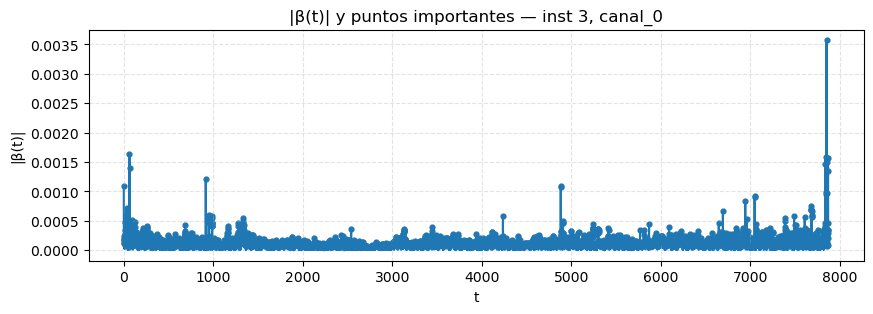

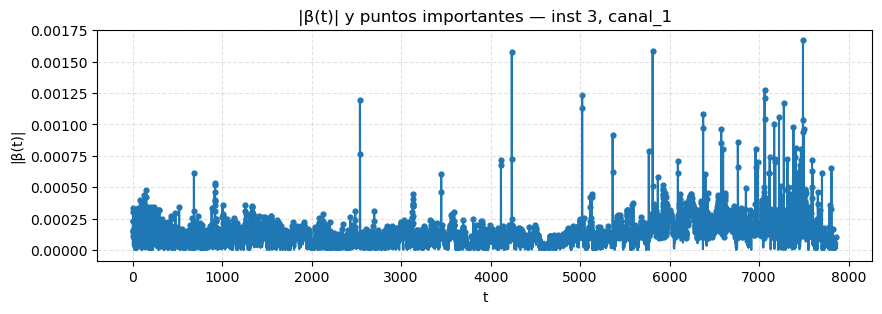

Δf=1.109935 | Σβ(T,C)=1.109935


In [28]:
#Instancia
i = 3
x_raw  = X_test[i:i+1]  
y_true = int(y_test[i])

X0_op, cls_opp = pick_opposite_channelwise_baseline(
    x_raw=x_raw, y_true=y_true, clf_phi=clf_phi,
    ch_medoids=ch_medoids, fallback_medoids=None,
    transform_prime=mmv.transform_prime
)

out_x  = mmv.transform_prime(x_raw);   phi_x, traces   = out_x["phi"], out_x["traces"]
out_x0 = mmv.transform_prime(X0_op);   phi_x0          = out_x0["phi"]
traces0 = mmv.transform_prime(X0_op)["traces"]


phi_x_s  = clf_phi.named_steps["standardscaler"].transform(phi_x)
phi_x0_s = clf_phi.named_steps["standardscaler"].transform(phi_x0)
cls_idx  = int(np.argmax(clf_phi.predict_proba(phi_x)[0]))
def _margin_for_class(model, Zs, c):
    z = model.decision_function(Zs); z = np.asarray(z)
    return float(z[0] if z.ndim==1 else z[0, c])
fx  = _margin_for_class(lr, phi_x_s,  cls_idx)
fx0 = _margin_for_class(lr, phi_x0_s, cls_idx)
delta_f = fx - fx0

W = lr.coef_
w_c = W[cls_idx] if (W.ndim==2 and W.shape[0]>1) else (W.ravel() if cls_idx==1 else -W.ravel())
mu_bg_scaled = phi_bg_scaled.mean(axis=0)
alphas_raw = (phi_x_s[0] - mu_bg_scaled) * w_c
alphas = mmv.calibrate_alphas_to_delta_f(alphas_raw, delta_f, phi_x_s, phi_x0_s)


x_tc, x0_tc = x_raw[0].T, X0_op[0].T
sigma_ref = [tr0["sigma"] for tr0 in traces0]
beta_TC = mmv.back_propagate_attribution(alphas, traces, x_tc, x0_tc,
                                         sigma_ref=sigma_ref, mode="channel_energy",
                                         per_channel=True)  # (T,C)

T, C = beta_TC.shape
CH_NAMES = [f"canal_{j}" for j in range(C)] if 'CH_NAMES' not in globals() else list(CH_NAMES)

def top50_mask_per_channel(beta_TC):
    T, C = beta_TC.shape
    m = np.zeros((T,C), dtype=bool)
    for c in range(C):
        mag = np.abs(beta_TC[:, c])
        k = max(1, int(0.5*T))
        idx = np.argpartition(mag, -k)[-k:]
        m[idx, c] = True
    return m

mask_TC = top50_mask_per_channel(beta_TC)

t = np.arange(T)
for c, name in enumerate(CH_NAMES):
    plt.figure(figsize=(10,3))
    plt.plot(t, np.abs(beta_TC[:, c]))
    sel = mask_TC[:, c]
    if sel.any():
        plt.scatter(t[sel], np.abs(beta_TC[sel, c]), s=12)
    plt.title(f"|β(t)| y puntos importantes — inst {i}, {name}")
    plt.xlabel("t"); plt.ylabel("|β(t)|")
    plt.grid(True, ls='--', alpha=0.35)
    plt.show()

print(f"Δf={delta_f:.6f} | Σβ(T,C)={float(beta_TC.sum()):.6f}")


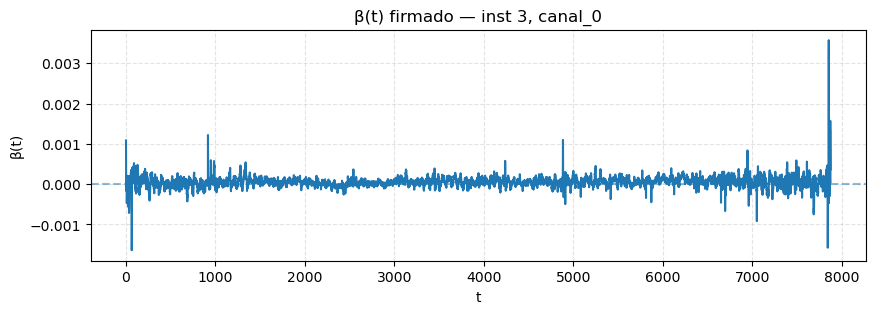

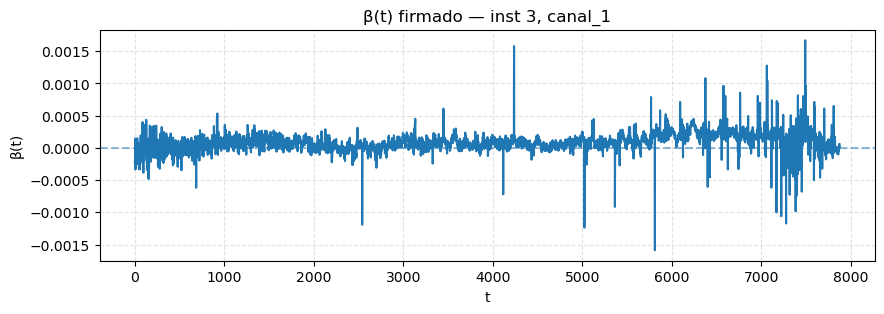

In [30]:
for c, name in enumerate(CH_NAMES):
    plt.figure(figsize=(10,3))
    plt.plot(np.arange(T), beta_TC[:, c])  # sin abs
    plt.axhline(0, ls='--', alpha=0.5)
    plt.title(f"β(t) firmado — inst {i}, {name}")
    plt.xlabel("t"); plt.ylabel("β(t)")
    plt.grid(True, ls='--', alpha=0.35)
    plt.show()


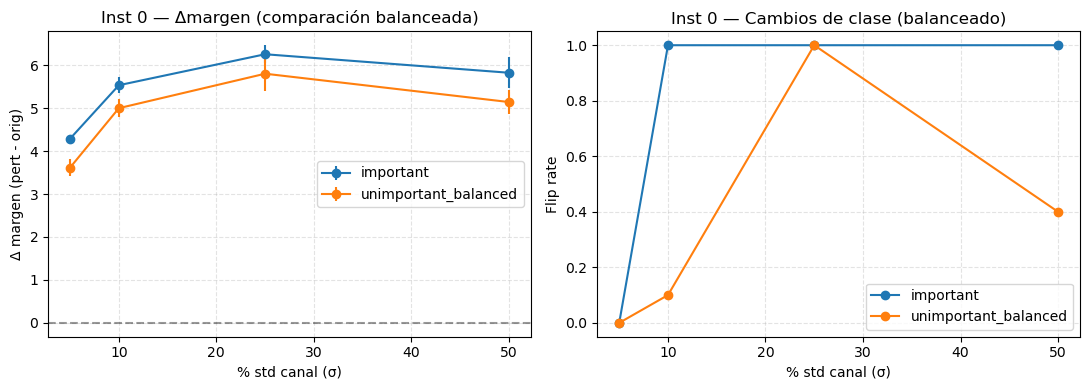

tag  sigma_pct  delta_mean  delta_std  flip_rate
0             important       0.05    4.289436   0.086457        0.0
1             important       0.10    5.534323   0.186283        1.0
2             important       0.25    6.255935   0.210227        1.0
3             important       0.50    5.824871   0.362797        1.0
4  unimportant_balanced       0.05    3.616657   0.205557        0.0
5  unimportant_balanced       0.10    4.999804   0.204272        0.1
6  unimportant_balanced       0.25    5.802415   0.401885        1.0
7  unimportant_balanced       0.50    5.142650   0.281366        0.4

In [34]:

PCT = 0.20   # CAMBIAR AQUI % de timestamps importantes por canal (0.50=top-50%, 0.20=top-20%)
SIGMA_PCTS = [0.05, 0.10, 0.25, 0.50]
N_PERTURB  = 10
rng = np.random.default_rng(2025)

i = 0
x_raw  = X_test[i:i+1]
y_true = int(y_test[i])

def _margin_for_class(lr_model, Zs, c):
    z = lr_model.decision_function(Zs); z = np.asarray(z)
    return float(z[0] if z.ndim==1 else z[0, c])

if 'beta_TC' not in globals():
    # baseline por canal
    X0_op, cls_opp = pick_opposite_channelwise_baseline(
        x_raw=x_raw, y_true=y_true, clf_phi=clf_phi,
        ch_medoids=ch_medoids, fallback_medoids=None,
        transform_prime=mmv.transform_prime
    )

    out_x  = mmv.transform_prime(x_raw);  phi_x, traces = out_x["phi"], out_x["traces"]
    out_x0 = mmv.transform_prime(X0_op);  phi_x0        = out_x0["phi"]; traces0 = out_x0["traces"]

    scaler = clf_phi.named_steps["standardscaler"]
    phi_x_s  = scaler.transform(phi_x)
    phi_x0_s = scaler.transform(phi_x0)
    cls_idx  = int(np.argmax(clf_phi.predict_proba(phi_x)[0]))
    fx  = _margin_for_class(lr, phi_x_s,  cls_idx)
    fx0 = _margin_for_class(lr, phi_x0_s, cls_idx)
    delta_f = fx - fx0


    W = lr.coef_
    w_c = W[cls_idx] if (W.ndim==2 and W.shape[0]>1) else (W.ravel() if cls_idx==1 else -W.ravel())
    try:
        mu_bg_scaled  
    except NameError:

        idx_bg = np.random.default_rng(0).choice(len(X_train), size=min(64, len(X_train)), replace=False)
        phi_bg = np.vstack([mmv.transform_prime(X_train[k:k+1])["phi"] for k in idx_bg])
        mu_bg_scaled = scaler.transform(phi_bg).mean(axis=0)

    alphas_raw = (phi_x_s[0] - mu_bg_scaled) * w_c
    alphas = mmv.calibrate_alphas_to_delta_f(alphas_raw, delta_f, phi_x_s, phi_x0_s)

    x_tc, x0_tc = x_raw[0].T, X0_op[0].T
    sigma_ref = [tr0["sigma"] for tr0 in traces0]
    beta_TC = mmv.back_propagate_attribution(alphas, traces, x_tc, x0_tc,
                                             sigma_ref=sigma_ref, mode="channel_energy",
                                             per_channel=True)

T, C = beta_TC.shape

def top_p_mask_per_channel(beta_TC, p=0.5):
    T, C = beta_TC.shape
    m = np.zeros((T, C), dtype=bool)
    k = max(1, int(np.ceil(p*T)))
    for c in range(C):
        mag = np.abs(beta_TC[:, c])
        idx = np.argpartition(mag, -k)[-k:]
        m[idx, c] = True
    return m

def balanced_unimportant_mask(mask_imp, rng=None):
    rng = rng or np.random.default_rng(123)
    T, C = mask_imp.shape
    m = np.zeros((T, C), dtype=bool)
    for c in range(C):
        k = int(mask_imp[:, c].sum())
        cand = np.flatnonzero(~mask_imp[:, c])
        pick = rng.choice(cand, size=k, replace=False)
        m[pick, c] = True
    return m

mask_imp       = top_p_mask_per_channel(beta_TC, p=PCT)    
mask_unimp_bal = balanced_unimportant_mask(mask_imp, rng=rng)


def gaussian_perturb_on_mask(x_raw, mask_TC, sigma_pct_list, n_per_level, rng=None):
    rng = rng or np.random.default_rng(123)
    _, C, L = x_raw.shape
    x_tc = x_raw[0].T
    std_c = x_tc.std(axis=0, ddof=0)
    T = x_tc.shape[0]
    results = []
    for sp in sigma_pct_list:
        for rep in range(n_per_level):
            noise_tc = np.zeros_like(x_tc, dtype=np.float32)
            for c in range(C):
                sigma = float(sp * std_c[c])
                if sigma > 0:
                    nvec = rng.normal(0.0, sigma, size=T).astype(np.float32)
                    noise_tc[mask_TC[:, c], c] = nvec[mask_TC[:, c]]
            x_pert = (x_tc + noise_tc).T[None, ...]
            results.append((sp, rep, x_pert))
    return results

def run_set(mask_TC, tag):
    rows=[]
    phi_x  = mmv.transform_prime(x_raw)["phi"]
    y0     = int(clf_phi.predict(phi_x)[0])
    phi_xs = clf_phi.named_steps["standardscaler"].transform(phi_x)
    # usa la misma clase objetivo que beta_TC (cls_idx si está en el entorno)
    try:
        _ = cls_idx
    except NameError:
        cls_idx = int(np.argmax(clf_phi.predict_proba(phi_x)[0]))
    m0     = _margin_for_class(lr, phi_xs, cls_idx)

    for sp, rep, x_pert in gaussian_perturb_on_mask(x_raw, mask_TC, SIGMA_PCTS, N_PERTURB, rng=rng):
        phi_p  = mmv.transform_prime(x_pert)["phi"]
        yp     = int(clf_phi.predict(phi_p)[0])
        phi_ps = clf_phi.named_steps["standardscaler"].transform(phi_p)
        mp     = _margin_for_class(lr, phi_ps, cls_idx)
        rows.append({"tag":tag,"sigma_pct":sp,"rep":rep,
                     "delta_margin":mp-m0,"flipped":int(yp!=y0)})
    return pd.DataFrame(rows)

df_imp   = run_set(mask_imp,       "important")
df_unimp = run_set(mask_unimp_bal, "unimportant_balanced")
df_join  = pd.concat([df_imp, df_unimp], ignore_index=True)

agg = df_join.groupby(["tag","sigma_pct"]).agg(
    delta_mean=("delta_margin","mean"),
    delta_std =("delta_margin","std"),
    flip_rate=("flipped","mean")
).reset_index()

fig, ax = plt.subplots(1,2, figsize=(11,4))

for tag, sub in agg.groupby("tag"):
    ax[0].errorbar(sub["sigma_pct"]*100, sub["delta_mean"], yerr=sub["delta_std"], fmt='-o', label=tag)
ax[0].axhline(0, ls='--', c='k', alpha=.4)
ax[0].set_xlabel("% std canal (σ)"); ax[0].set_ylabel("Δ margen (pert - orig)")
ax[0].set_title(f"Inst {i} — Δmargen (comparación balanceada)"); ax[0].grid(True, ls='--', alpha=.35); ax[0].legend()

for tag, sub in agg.groupby("tag"):
    ax[1].plot(sub["sigma_pct"]*100, sub["flip_rate"], '-o', label=tag)
ax[1].set_xlabel("% std canal (σ)"); ax[1].set_ylabel("Flip rate")
ax[1].set_title(f"Inst {i} — Cambios de clase (balanceado)"); ax[1].grid(True, ls='--', alpha=.35); ax[1].legend()

plt.tight_layout(); plt.show()
display(agg)


In [35]:
# RANKING RÁPIDO: Validar qué instancias son las mejores para explicar
import numpy as np, pandas as pd

PCT = 0.20                   
SIGMA_PCTS = [0.10, 0.25]    
N_PERTURB  = 5              

def top_p_mask_per_channel(beta_TC, p=0.5):
    T, C = beta_TC.shape
    m = np.zeros((T, C), dtype=bool)
    k = max(1, int(np.ceil(p*T)))
    for c in range(C):
        mag = np.abs(beta_TC[:, c])
        idx = np.argpartition(mag, -k)[-k:]
        m[idx, c] = True
    return m

def balanced_unimportant_mask(mask_imp, rng=None):
    rng = rng or np.random.default_rng(123)
    T, C = mask_imp.shape
    m = np.zeros((T, C), dtype=bool)
    for c in range(C):
        k = int(mask_imp[:, c].sum())
        cand = np.flatnonzero(~mask_imp[:, c])
        pick = rng.choice(cand, size=k, replace=False)
        m[pick, c] = True
    return m

def _margin_for_class(lr_model, Zs, c):
    z = lr_model.decision_function(Zs); z = np.asarray(z)
    return float(z[0] if z.ndim==1 else z[0, c])

def gaussian_perturb_on_mask(x_raw, mask_TC, sigma_pct_list, n_per_level, rng=None):
    rng = rng or np.random.default_rng(123)
    _, C, L = x_raw.shape
    x_tc = x_raw[0].T
    std_c = x_tc.std(axis=0, ddof=0)
    T = x_tc.shape[0]
    results = []
    for sp in sigma_pct_list:
        for rep in range(n_per_level):
            noise_tc = np.zeros_like(x_tc, dtype=np.float32)
            for c in range(C):
                sigma = float(sp * std_c[c])
                if sigma > 0:
                    nvec = rng.normal(0.0, sigma, size=T).astype(np.float32)
                    noise_tc[mask_TC[:, c], c] = nvec[mask_TC[:, c]]
            x_pert = (x_tc + noise_tc).T[None, ...]
            results.append((sp, rep, x_pert))
    return results

def score_instance(i):
    rng = np.random.default_rng(42+i)
    x_raw = X_test[i:i+1]

    X0_op, cls_opp = pick_opposite_channelwise_baseline(
        x_raw=x_raw, y_true=int(y_test[i]), clf_phi=clf_phi,
        ch_medoids=ch_medoids, fallback_medoids=None,
        transform_prime=mmv.transform_prime
    )
    out_x  = mmv.transform_prime(x_raw);  phi_x, traces = out_x["phi"], out_x["traces"]
    out_x0 = mmv.transform_prime(X0_op);  phi_x0        = out_x0["phi"]
    scaler = clf_phi.named_steps["standardscaler"]
    phi_x_s  = scaler.transform(phi_x)
    phi_x0_s = scaler.transform(phi_x0)
    cls_idx  = int(np.argmax(clf_phi.predict_proba(phi_x)[0]))
    fx  = _margin_for_class(lr, phi_x_s,  cls_idx)
    fx0 = _margin_for_class(lr, phi_x0_s, cls_idx)
    delta_f = fx - fx0
    # alphas cerrados + calibración
    W = lr.coef_
    w_c = W[cls_idx] if (W.ndim==2 and W.shape[0]>1) else (W.ravel() if cls_idx==1 else -W.ravel())
    mu_bg_scaled = phi_bg_scaled.mean(axis=0)
    alphas_raw = (phi_x_s[0] - mu_bg_scaled) * w_c
    alphas = mmv.calibrate_alphas_to_delta_f(alphas_raw, delta_f, phi_x_s, phi_x0_s)
    # β por canal
    x_tc, x0_tc = x_raw[0].T, X0_op[0].T
    traces0 = mmv.transform_prime(X0_op)["traces"]
    sigma_ref = [tr0["sigma"] for tr0 in traces0]
    beta_TC = mmv.back_propagate_attribution(alphas, traces, x_tc, x0_tc,
                                             sigma_ref=sigma_ref, mode="channel_energy",
                                             per_channel=True)
  
    mask_imp = top_p_mask_per_channel(beta_TC, p=PCT)
    mask_unb = balanced_unimportant_mask(mask_imp, rng=rng)

    m0 = _margin_for_class(lr, phi_x_s, cls_idx)
    y0 = int(clf_phi.predict(phi_x)[0])

 
    rows=[]
    for tag, mask in [("imp", mask_imp), ("unb", mask_unb)]:
        for sp, rep, x_pert in gaussian_perturb_on_mask(x_raw, mask, SIGMA_PCTS, N_PERTURB, rng=rng):
            phi_p  = mmv.transform_prime(x_pert)["phi"]
            yp     = int(clf_phi.predict(phi_p)[0])
            phi_ps = scaler.transform(phi_p)
            mp     = _margin_for_class(lr, phi_ps, cls_idx)
            rows.append((tag, sp, mp-m0, int(yp!=y0)))
    df = pd.DataFrame(rows, columns=["tag","sigma","dm","flip"])

    g1 = df[df.tag=="imp"].groupby("sigma")["dm"].mean() - df[df.tag=="unb"].groupby("sigma")["dm"].mean()
    g2 = df[df.tag=="imp"].groupby("sigma")["flip"].mean() - df[df.tag=="unb"].groupby("sigma")["flip"].mean()
    return {
        "i": i,
        "gap_dm_mean": float(g1.mean()),
        "gap_flip_mean": float(g2.mean()),
        "gap_dm@10%": float(g1.get(0.10, np.nan)),
        "gap_flip@10%": float(g2.get(0.10, np.nan)),
    }


scores = [score_instance(i) for i in range(len(X_test))]
rank = pd.DataFrame(scores).sort_values(["gap_dm_mean","gap_flip_mean"], ascending=False)
print(rank.head(10))


best_i = int(rank.iloc[0]["i"])
print("Sugerencia de instancia para graficar:", best_i)


KeyboardInterrupt: 